In [1]:
from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
%gui tk
#lam_val = {'inner':100, 'outer':0, 'third':100}
#lam = CoefficientFunction([lam_val[x] for x in mesh.GetMaterials()])

In [2]:
#      3---------------------------2 
#      |                           |
#      |                     (1)   |
#      |                           |
#      |                           |
#      |  7----6     11----10      |
#      |  | (2)|      |    |       |
#      |  |    |      | (3)|       |
#      |  4----5      8----9       |
#      |                           |
#      |                           |
#      |                           |
#      0---------------------------1

def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,1), (0,1), 
             (0.2,0.45), (0.3,0.45), (0.3,0.55), (0.2,0.55),
             (0.7,0.45), (0.8,0.45), (0.8,0.55), (0.7,0.55),
             (0.75,0.45), (0.75,0.55),
             (0.7,0.5), (0.75,0.5)]
    p = [geometry.AppendPoint(*p) for p in pnts]
        
    lines = [[p[0], p[1], 1, 0, "bnd_outer"],
             [p[1], p[2], 1, 0, "bnd_outer"],
             [p[2], p[3], 1, 0, "bnd_outer"],
             [p[3], p[0], 1, 0, "bnd_outer"],
             [p[4], p[5], 2, 1, "bnd_inner"],
             [p[5], p[6], 2, 1, "bnd_inner"],
             [p[6], p[7], 2, 1, "bnd_inner"],
             [p[7], p[4], 2, 1, "bnd_inner"],
             [p[8], p[9], 3, 1, "bnd_int_1"],
             [p[9], p[10], 3, 1, "bnd_int_1"],
             [p[10], p[11], 3, 1, "bnd_int_1"],
             [p[11], p[8], 3, 1, "bnd_int_1"],
             [p[12], p[13], 3, 3, "bnd_int_2"],
             #[p[14], p[15], 3, 3, "bnd_int_3"]
            ]
    
    
    for start_point, end_point, ld, rd, name in lines:
        geometry.Append(["line", start_point, end_point], leftdomain=ld, rightdomain=rd ,bc=name) 

    geometry.SetMaterial(1,'outer')
    geometry.SetMaterial(3,'int_vol')
    geometry.SetMaterial(2,'inner')

    return geometry

In [3]:
geo = MakeGeometry()
mesh = Mesh(geo.GenerateMesh (maxh=0.05))
Draw(mesh)
mesh.GetMaterials()

fes = H1(mesh, order=3, dirichlet='bnd_outer')
u = fes.TrialFunction()
v = fes.TestFunction()
f = LinearForm(fes)

a = BilinearForm(fes, symmetric=True)
a += SymbolicBFI(grad(u)*grad(v))

c = Preconditioner(a, type="multigrid", inverse = "sparsecholesky")

gfu = GridFunction(fes)
Draw(gfu)

space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")
Draw(gf_flux)


In [4]:
def SolveBVP(isThird=False):
    fes.Update()
    gfu.Update()
    a.Assemble()
    f.Assemble()
    if(isThird):
        f.vec[97-1]=1
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)

In [5]:
def CalcError():
    space_flux.Update()
    gf_flux.Update()
    flux = grad(gfu) 
    # interpolate finite element flux into H(div) space:
    gf_flux.Set (flux)
    
    # Gradient-recovery error estimator
    err = (flux-gf_flux)*(flux-gf_flux)
    elerr = Integrate (err, mesh, VOL, element_wise=True) #todo über bnd_integration integrieren
    maxerr = max(elerr)
    print ("maxerr = ", maxerr)
    return elerr
    #for el in mesh.Elements():
    #    mesh.SetRefinementFlag(el, elerr[el.nr] > 0.25*maxerr)
     

In [6]:
l1=[]
with TaskManager():
    while fes.ndof < 10000:
        f = LinearForm(fes)
        f += SymbolicLFI(100*v, definedon=mesh.Materials("inner"))
        SolveBVP()
        elerr_f = CalcError()

        f = LinearForm(fes)
        f += SymbolicLFI(100*v, definedon=mesh.Materials("int_vol"))
        SolveBVP()
        elerr_b1 = CalcError()

        elerr_tot = []
        for i in range(0,len(elerr_b1)):
            elerr_tot.append(elerr_b1[i]*elerr_f[i])

        maxerr_tot = max(elerr_tot)
        l1.append ( (fes.ndof, sqrt(sum(elerr_tot)) ))
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, elerr_tot[el.nr] > 0.25*maxerr_tot)    
        print("error estimater ", maxerr_tot)

        mesh.Refine()

    SolveBVP()

maxerr =  2.8879907375959308e-06
maxerr =  3.251700629108238e-06
error estimater  3.4583893057465787e-18
maxerr =  1.4695447840987584e-06
maxerr =  2.4001045532952045e-06
error estimater  3.1291383765005247e-19
maxerr =  1.4695631569129715e-06
maxerr =  1.36523270630474e-06
error estimater  7.424526442592504e-20
maxerr =  7.500810790039464e-07
maxerr =  8.543699011038033e-07
error estimater  1.821023276487124e-20
maxerr =  7.498095446198082e-07
maxerr =  3.485668710397066e-07
error estimater  4.4513113216329965e-21
maxerr =  6.248311797144376e-07
maxerr =  2.709486008140875e-07
error estimater  8.126621281880782e-22
maxerr =  1.2907757230911265e-07
maxerr =  2.63531080772522e-07
error estimater  1.7225650377986477e-22
maxerr =  8.240432562940116e-08
maxerr =  1.0265231847429544e-07
error estimater  4.162409373920099e-23


In [7]:
geo = MakeGeometry()
mesh = Mesh(geo.GenerateMesh (maxh=0.05))
Draw(mesh)
mesh.GetMaterials()

fes = H1(mesh, order=3, dirichlet='bnd_outer')
u = fes.TrialFunction()
v = fes.TestFunction()
f = LinearForm(fes)

a = BilinearForm(fes, symmetric=True)
a += SymbolicBFI(grad(u)*grad(v))

c = Preconditioner(a, type="multigrid", inverse = "sparsecholesky")

gfu = GridFunction(fes)
Draw(gfu)

space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")
Draw(gf_flux)

In [8]:
l2=[]
with TaskManager():
    while fes.ndof < 10000:
        f = LinearForm(fes)
        f += SymbolicLFI(100*v, definedon=mesh.Materials("inner"))
        SolveBVP()
        elerr_f = CalcError()

        f = LinearForm(fes)
        f += SymbolicLFI(100*v, definedon=mesh.Boundaries("bnd_int_2"))
        SolveBVP()
        elerr_b2 = CalcError()

        elerr_tot = []
        for i in range(0,len(elerr_b2)):
            elerr_tot.append(elerr_b2[i]*elerr_f[i])

        maxerr_tot = max(elerr_tot)
        l2.append ( (fes.ndof, sqrt(sum(elerr_tot)) ))
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, elerr_tot[el.nr] > 0.25*maxerr_tot)    
        print("error estimater ", maxerr_tot)

        mesh.Refine()

    SolveBVP()

maxerr =  2.887990737595761e-06
maxerr =  2.083306169065416
error estimater  1.6140411986319987e-12
maxerr =  2.8879905557473167e-06
maxerr =  0.5113408579931586
error estimater  1.64485115272523e-14
maxerr =  2.887990559920112e-06
maxerr =  0.523276255858908
error estimater  2.1655909021938056e-15
maxerr =  2.887990767211411e-06
maxerr =  0.13034619862733188
error estimater  2.1294547318163086e-16
maxerr =  1.4695453516300633e-06
maxerr =  0.1303458684321266
error estimater  3.7699188693410045e-17
maxerr =  1.4695404606580483e-06
maxerr =  0.13034584085052037
error estimater  7.813105201871724e-18
maxerr =  7.500785743293553e-07
maxerr =  0.06514824465862998
error estimater  1.7376677651106e-18
maxerr =  7.498046376005472e-07
maxerr =  0.06514819776325573
error estimater  4.3013942933207846e-19
maxerr =  6.249308376559007e-07
maxerr =  0.06514804824070158
error estimater  9.621046800760759e-20
maxerr =  1.2908524426639968e-07
maxerr =  0.03255661168827313
error estimater  2.8936286026

In [9]:
geo = MakeGeometry()
mesh = Mesh(geo.GenerateMesh (maxh=0.05))
Draw(mesh)
mesh.GetMaterials()

fes = H1(mesh, order=3, dirichlet='bnd_outer')
u = fes.TrialFunction()
v = fes.TestFunction()
f = LinearForm(fes)

a = BilinearForm(fes, symmetric=True)
a += SymbolicBFI(grad(u)*grad(v))

c = Preconditioner(a, type="multigrid", inverse = "sparsecholesky")

gfu = GridFunction(fes)
Draw(gfu)

space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")
Draw(gf_flux)

In [10]:
l3=[]
with TaskManager():
    while fes.ndof < 10000:
        f = LinearForm(fes)
        f += SymbolicLFI(100*v, definedon=mesh.Materials("inner"))
        SolveBVP()
        elerr_f = CalcError()

        f = LinearForm(fes)
        #f += SymbolicLFI(100*v, definedon=mesh.Boundaries("bnd_int_2"))
        SolveBVP(True)
        elerr_b3 = CalcError()
        elerr_tot = []
        for i in range(0,len(elerr_b3)):
            elerr_tot.append(elerr_b3[i]*elerr_f[i])

        maxerr_tot = max(elerr_tot)
        l3.append ( (fes.ndof, sqrt(sum(elerr_tot)) ))
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, elerr_tot[el.nr] > 0.25*maxerr_tot)    
        print("error estimater ", maxerr_tot)

        mesh.Refine()
    SolveBVP()


maxerr =  2.8879907375955386e-06
maxerr =  0.2431551107180091
error estimater  2.167470130915259e-13
maxerr =  2.8879907451728726e-06
maxerr =  0.13521596174017964
error estimater  5.913798090285309e-16
maxerr =  2.88799079853259e-06
maxerr =  0.13525739694623312
error estimater  3.71707415655047e-18
maxerr =  2.0244286283881843e-06
maxerr =  0.13525739202759748
error estimater  3.159121261164474e-19
maxerr =  8.476675791947074e-07
maxerr =  0.13525739218669613
error estimater  6.87808722139999e-20
maxerr =  8.476683623342826e-07
maxerr =  0.1352573921356277
error estimater  1.3330775633671541e-20
maxerr =  7.498445881000856e-07
maxerr =  0.13525739219322072
error estimater  3.453780144377138e-21
maxerr =  3.2741763145291554e-07
maxerr =  0.13525739233935244
error estimater  8.17473023352585e-22
maxerr =  1.2907747635067153e-07
maxerr =  0.1352573924430579
error estimater  3.0960317476426015e-22
maxerr =  1.2907746234854323e-07
maxerr =  0.13525739222452385
error estimater  8.344883807

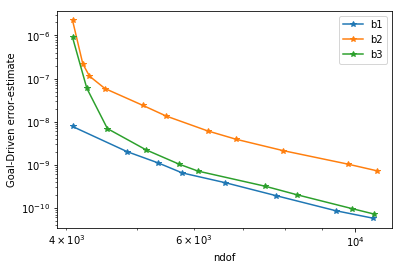

<press enter to quit> 


''

In [12]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")

plt.ylabel("Goal-Driven error-estimate")

ndof,err = zip(*l1)
plt.plot(ndof,err, "-*", label="b1")
ndof,err = zip(*l2)
plt.plot(ndof,err, "-*", label="b2")
ndof,err = zip(*l3)
plt.plot(ndof,err, "-*", label="b3")
plt.legend()
plt.ion()
plt.show()
input("<press enter to quit>")

In [19]:
gfu = GridFunction(fes)
gfu.vec[96] = 1
Draw(gfu)